# <center> Deep Learning Project: Bankruptcy Prediction Model

## Author
> - __Omar Jarir__ (m20201378)  

***

## Objective
The objective of this notebook is to build the best model to predict if a company is going to default using deep learning models. We will explore hyper parameter tuning, down-sampling and over-sampling.


## Install Packages

__Uncomment this cell if you don't have this packages__

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
# !pip install findspark
# !pip install tensorflow-addons
# !pip install shap

In [2]:
import time
t1 = time.perf_counter()

__Importing the necessary libraries 📚:__

In [3]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, f_classif 
from sklearn.utils import class_weight

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import shap

from operator import add
import IPython


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
SEED = 2022
FIGSIZE = (10, 10)
N_EPOCHS = 100

Fixing the random number seed to ensure that the results are reproducible.

In [6]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

## Helper Functions

In [7]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain, average='macro'),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain, average='macro'),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest, average='macro'),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest, average='macro'), 
               ]
    resultsDF = pd.DataFrame({'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [8]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [9]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [10]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi = mi.sort_values(ascending=False)
    mi.plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [11]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    return f_scores

In [12]:
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    return p

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    r = tp / (tp + fn + K.epsilon())
    return r

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [13]:
def remove_correlated(X, threshold=0.9):
    corr = np.absolute(X.corr())
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if row[col] > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than threshold
    correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > threshold)]
    # Drop correlated columns
    return correlated_cols

In [14]:
def remove_outliers(x_train, x_test, y_train, y_test, cols, estimators=100):
    ''' 
    Uses an isolation forest in order to detect and remove outliers.
    '''
    isolation_forest = IsolationForest(n_estimators=estimators, random_state=SEED)
    
    #identify outliers:
    y_train_pred = isolation_forest.fit_predict(x_train[cols])
    y_test_pred = isolation_forest.predict(x_test[cols])

    #Remove outliers where 1 represent inliers and -1 represent outliers:
    x_train = x_train[np.where(y_train_pred == 1, True, False)]
    x_test = x_test[np.where(y_test_pred == 1, True, False)]

    y_train = y_train[np.where(y_train_pred == 1, True, False)]
    y_test = y_test[np.where(y_test_pred == 1, True, False)] 
    
    return x_train, x_test, y_train, y_test

In [15]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_history(history, metrics, title):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    loss = history.history[metrics]
    val_loss = history.history[f"val_{metrics}"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label=f"Training {metrics}", figsize=FIGSIZE)
    plt.plot(epochs, val_loss, "b", label=f"Validation {metrics}", figsize=FIGSIZE)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metrics)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [16]:
def auc_plot(y_test, y_pred_test_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.grid(axis='both', linestyle='--', color="#add8e6")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

In [17]:
def oversample(ratio, x_train, y_train):
    sm = SMOTE(random_state=SEED, sampling_strategy=ratio)
    return sm.fit_resample(x_train, y_train)
    
def undersample(ratio, x_train, y_train, version):
    sm = NearMiss(version=version, sampling_strategy=ratio)
    return sm.fit_resample(x_train, y_train)

## Loading the dataset
The dataset is from 
    - https://www.kaggle.com/datasets/blastchar/telco-customer-churn.

In [18]:
ds= pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
ds.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# Checking the shape of the dataset:
ds.shape

(7043, 21)

### Checking for missing values


In [20]:
ds['TotalCharges'] = pd.to_numeric(ds['TotalCharges'], errors='coerce')

In [21]:
ds.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [22]:
ds.dropna(inplace=True)

### Check for Duplicates
There are no duplicate rows in this dataset

In [23]:
ds.duplicated().sum()

0

In [24]:
# Droping the column 'CustomerID' since it is not useful:
ds.drop(columns=['customerID'], inplace=True)

### Check Data type
All the columns are numeric. There are 2 binary flags that are already enocoded as 0 or 1.
- 85: Liability-Assets Flag
- 94: Net Income Flag

In [25]:
ds.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [26]:
ds["TotalCharges"].value_counts()

20.20      11
19.75       9
20.05       8
19.90       8
19.65       8
           ..
6849.40     1
692.35      1
130.15      1
3211.90     1
6844.50     1
Name: TotalCharges, Length: 6530, dtype: int64

In [27]:
ds["TotalCharges"] = ds["TotalCharges"].astype(float)

### Check Class Distribution
The target is dominated by class 0 - no bankruptcy

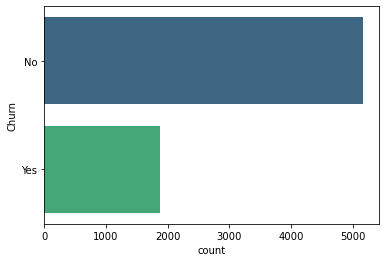

In [28]:
sns.countplot(y='Churn', data = ds, palette='viridis', orient = 'h');

In [29]:
ds["Churn"].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

### Split Target from Predictive Variables
- X: predictive variables
- y: target variable

In [30]:
ds["Churn"] = np.where(ds["Churn"] == 'Yes', 1, 0)
X = ds.copy(deep=True)

y = X["Churn"]
X = X.drop(columns=["Churn"])

## Data Preparation

### Splitting the dataset
We splti 30% for testing. The sampling is stratified to make sure training and testing have the same distribution of target variable.

In [31]:
# Split the dataset intro train and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                shuffle = True, stratify=y, random_state=SEED)

### Correlation
We remove features whose absolute correlation coefficient are greater than 0.9

In [32]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

### Dealing with outliers
Random forests is efficient at detecting outliers in high-dimensional dataset https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest. Isolation forest algorithm randomly selects a feature and splits it between the min and max. This process is repeated recuresively to partition the outliers

In [33]:
print(x_train.shape)
print(x_test.shape)

(5625, 19)
(1407, 19)


In [34]:
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]
x_train, x_test, y_train, y_test = remove_outliers(x_train, x_test, y_train, y_test, num_features)

In [35]:
print(x_train.shape)
print(x_test.shape)

(2466, 19)
(595, 19)


In [36]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.64193
1    0.35807
Name: Churn, dtype: float64
0    0.640336
1    0.359664
Name: Churn, dtype: float64


### Dimension Reduction
We compute mutual information score and ANOVA F-value. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py explains that mutual information is an entrpoy-based method that is better at measuring non-linear relationship, whereas F-test statistics are better at measuring linear relationship.
We drop columns with low mutual information score or ANOVA F-value.

In [37]:
# mi_scores = MutualInfoScores(x_train, y_train)
# mi_scores.loc[mi_scores > 0.2]

In [38]:
# mi_scores.loc[mi_scores > 0.2].index

In [39]:
# f_scores = FTestScores(x_train, y_train)
# f_scores.loc[f_scores > 0.1]

In [40]:
# high_mi_columns = mi_scores.loc[mi_scores > 0.2].index
# high_f_score_columns = f_scores.loc[f_scores > 0.1].index
# kept_columns = high_mi_columns.union(high_f_score_columns).values 
# x_train = x_train[kept_columns]
# x_test = x_test[kept_columns]

# print(f"Keep {len(kept_columns)} columns")
# kept_columns

In [41]:
# x_train = x_train[kept_columns]
# x_test = x_test[kept_columns]

### Data Normalization:
We use the standard scaler to normalize the data

In [42]:
scaler = StandardScaler() 
x_train[num_features] = scaler.fit_transform(x_train[num_features]) 
x_test[num_features] = scaler.transform(x_test[num_features])

### Ecoding the categorical features:

In [43]:
cat_features = list(set(x_train.columns).difference(num_features).difference(["SeniorCitizen"]))

In [44]:
# I guess it is useless, will check it later.
for col in cat_features:
    x_train[col] = x_train[col].astype('category')
    x_test[col] = x_test[col].astype('category')

In [45]:
for col in cat_features:
    print(x_train[col].unique())

['Yes', 'No', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['Bank transfer (automatic)', 'Electronic check', 'Credit card (automatic)', 'Mailed check']
Categories (4, object): ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['Yes', 'No']
Categories (2, object): ['No', 'Yes']
['Yes', 'No', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['Yes', 'No', 'No phone service']
Categories (3, object): ['No', 'No phone service', 'Yes']
['Yes', 'No']
Categories (2, object): ['No', 'Yes']
['Yes', 'No', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['No', 'Yes', 'No internet service']
Categories (3, object): ['No', 'No internet service', 'Yes']
['Fema

In [46]:
# We can perform one-hot encoding for categorical features:
encoder = OneHotEncoder(drop="if_binary", sparse=False)
x_train_cat = encoder.fit_transform(x_train[cat_features]) 
x_test_cat = encoder.transform(x_test[cat_features])

In [47]:
x_train = np.concatenate((x_train_cat, x_train[num_features].values), axis=1)
x_test = np.concatenate((x_test_cat, x_test[num_features].values), axis=1)

## Simple Model
First we try out a simple model to get a sense of number of hidden layers needed.

In [48]:
def simple_model(units, loss, x_train, y_train, x_test, y_test, epochs=20, batch_size=16, cw=None):
    '''
    units: a list for number of units in each layer. The length of the list determines the number of hidden layers
    loss: loss function to minimize
    '''
    model = Sequential()
    for u in units:
        model.add(layers.Dense(units=u, activation="relu"))
    
    # Last layer should always have 1 neuron with sigmoid activation function
    model.add(layers.Dense(units=1, activation="sigmoid"))
    model.compile(loss=loss, metrics=['accuracy'])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3,
        shuffle = True, stratify=y_train, random_state=SEED)
    # EarlyStop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)
    # CallBacksList = [EarlyStop,]  
    hist = model.fit(x_train, y_train, epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=cw,
        # callbacks = CallBacksList,
        verbose=0)
    
    y_pred_train_proba = model.predict(x_train)
    y_pred_test_proba = model.predict(x_test)
    y_pred_train = (y_pred_train_proba>0.5).astype(int)
    y_pred_test = (y_pred_test_proba>0.5).astype(int) 
    
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['0', '1']
    make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')
    return y_pred_test_proba, hist.history["val_loss"]

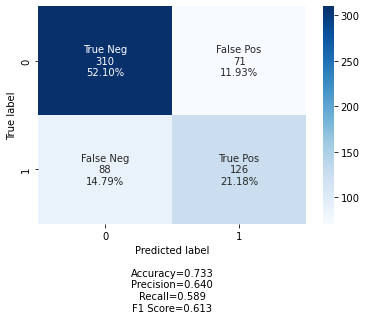

In [49]:
y_pred_test_proba, loss_1 = simple_model([64,32,16], tf.keras.losses.BinaryCrossentropy(),
                                        x_train, y_train, x_test, y_test)

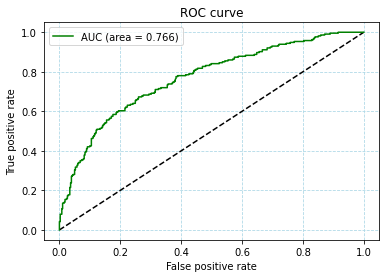

In [50]:
auc_plot(y_test, y_pred_test_proba)

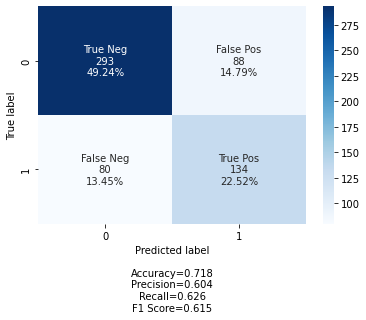

In [51]:
y_pred_test_proba, loss_2 = simple_model([64,32], tf.keras.losses.BinaryCrossentropy(),
                                        x_train, y_train, x_test, y_test)

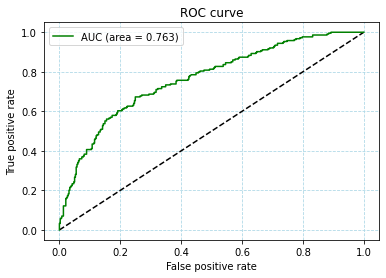

In [52]:
auc_plot(y_test, y_pred_test_proba)

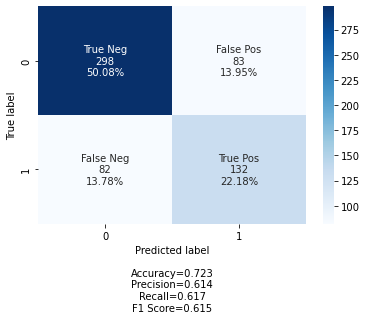

In [53]:
y_pred_test_proba, loss_3 = simple_model([64, 16], tf.keras.losses.BinaryCrossentropy(),
                                        x_train, y_train, x_test, y_test)

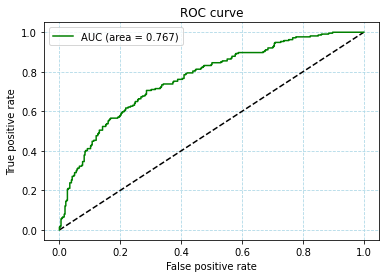

In [54]:
auc_plot(y_test, y_pred_test_proba)

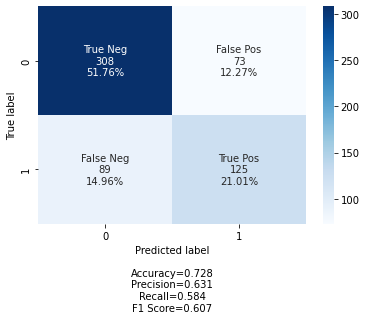

In [55]:
y_pred_test_proba, loss_4 = simple_model([32,16,4], tf.keras.losses.BinaryCrossentropy(),
                                        x_train, y_train, x_test, y_test)

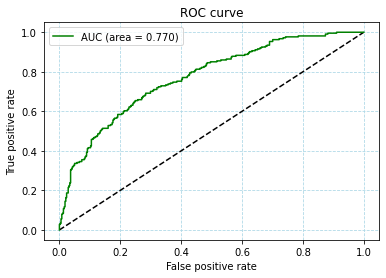

In [56]:
auc_plot(y_test, y_pred_test_proba)

A smaller neural network seems to generalize better for our dataset, because the dataset is small.

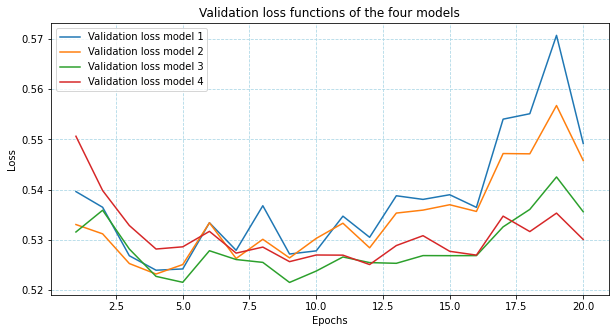

In [57]:
epochs = range(1, len(loss_1)+1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss_1, label = "Validation loss model 1")
plt.plot(epochs, loss_2, label = "Validation loss model 2")
plt.plot(epochs, loss_3, label = "Validation loss model 3")
plt.plot(epochs, loss_4, label = "Validation loss model 4")
plt.grid(axis='both', linestyle='--', color="#add8e6")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss functions of the four models')
plt.legend(loc="best")
plt.show();

## Hyper parameters tuning:
- __References:__
>- https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
>- https://keras.io/guides/keras_tuner/getting_started/
>- https://keras.io/api/utils/serialization_utils/
>- https://www.tensorflow.org/tutorials/keras/keras_tuner
>- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

### Class Weights
Because the target variable distribution is imbalanced, we use class weight to penalize wrong prediction of the minority class more.

In [58]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.7789008212255212, 1: 1.3963759909399773}

In [59]:
tune_objective = 'val_f1'
EarlyStop = EarlyStopping(monitor=tune_objective, patience=5, verbose=0, restore_best_weights=True) 
#ReduceLR = ReduceLROnPlateau(monitor=tune_objective, mode='max', factor=0.2, patience=3, min_lr=1e-5)

CallBacksList = [EarlyStop] # , ReduceLR  

### K-fold Validation
The dataset is small, so we use k-fold validation to make sure hyper parameter tuning evaluates models using all training data.

In [60]:
def kfold_split(x, y, k):
    x = np.array(x)
    y = np.array(y)
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    x_train, x_val, y_train, y_val = [], [], [], []
    for train_index, val_index in kfold.split(x, y):
        x_train.append(x[train_index])
        x_val.append(x[val_index])
        # Need to use y directly because y_train is Series
        y_train.append(y[train_index])
        y_val.append(y[val_index])
    return x_train, x_val, y_train, y_val

### Custom Model
We implement our own model class that inherits keras' hyper model. It allows tuning of the following parameters:
- Number of units in each layer
- Activation function: choose between sigmoid, relu and tanh
- Kernel initializer: How to set initial weight in each layer. We choose between Glorot normal initializer and Glorot uniform initializer. https://keras.io/api/layers/initializers/
- Learning rate: for the Adam optimizer https://keras.io/api/optimizers/adam/
- Loss type: binary classification or focal loss.
https://towardsdatascience.com/focal-loss-a-better-alternative-for-cross-entropy-1d073d92d075 provides a good explanation of their difference. In essence focal loss function focuses on cases that are misclassfified, so it's useful when the classes are imbalanced. It takes a parameter gamma.
- Dropout and dropout rate: What percent of the input should be set to 0. Use to regulate overfitting.
- Oversampling: We use Synthetic Minority Oversampling Technique (SMOTE) to generate more data points for the minority class.
- Undersampling: We use near miss strategy https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#prototype-selection-under-sampling-by-selecting-existing-samples to remove similar data points from the majority class

- Introduction to Bayesian Optimization: https://h1ros.github.io/posts/introduction-to-bayesian-optimization/ 

In [61]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, metrics=None, k=3):
        self.k = k
        if metrics:
            self.metrics = metrics
        else:
            self.metrics= [
                "accuracy",
                tf.keras.metrics.AUC(name="auc"), 
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                f1
            ]

    def build(self ,hp):
        hp_units_1 = hp.Choice("Layer 1", [32, 64]) # 128
        hp_units_2 = hp.Choice("Layer 2", [16, 32]) # 64
        hp_activation_1 = hp.Choice("activation 1", ["softplus", "relu", "tanh"]) # sigmoid
        hp_activation_2 = hp.Choice("activation 2", ["softplus", "relu", "tanh"]) # sigmoid
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-5)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.5, 2.0, 3.0])
        #hp_dropout_1 = hp.Choice("dropout rate 1", [0.1, 0.2, 0.5])
        hp_dropout_2 = hp.Choice("dropout rate 2", [0.1, 0.2, 0.5])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        activation = hp_activation_1,
                        input_dim = x_train.shape[-1]   
                           )) 

        #if hp.Boolean("Dropout 1"):
        #    model.add(layers.Dropout(rate=hp_dropout_1))
        
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation_2))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=hp_dropout_2))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics= self.metrics)
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                    metrics= self.metrics)
    
        return model

    
    def fit(self, hp, model, x, y, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64]) # 128
        hp_sample = hp.Choice("sample", ["over", "under", "none"])
        hp_oversample_rate = hp.Choice("oversample_rate", [ 0.8]) # 0.2, 0.4,
        hp_undersample_rate = hp.Choice("undersample_rate", [ 0.8]) # 0.2, 0.4,
        hp_near_miss_version = hp.Choice("near_miss_version", [1, 2])
        
        measures = ['val_precision', 'val_recall', 'val_f1', 'val_auc']
        results = pd.DataFrame(index=range(self.k), columns=measures)

        x_train, x_val, y_train, y_val = kfold_split(x, y, self.k)
        for i in range(self.k):
            x_train_i, y_train_i = x_train[i], y_train[i]
            # over/under sample after splitting validation data. Don't use synthetic data for validation.
            if hp_sample == 'over':
                x_train_i, y_train_i = oversample(hp_oversample_rate, x_train[i], y_train[i])
            elif hp_sample == 'under':
                x_train_i, y_train_i = undersample(hp_undersample_rate, x_train[i], y_train[i], hp_near_miss_version)
            hist = None
            ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train_i), y=y_train_i)))
            try:
                hist = model.fit(
                    x_train_i, y_train_i,
                    # Tune whether to shuffle the data in each epoch.
                    shuffle=hp.Boolean("shuffle"),
                    validation_data=(x_val[i], y_val[i]),
                    batch_size = hp_batch_size,
                    class_weight = ClassWeights,
                    **kwargs,
                )
                for m in measures:
                    results.iloc[i][m] = hist.history[m][-1]

            except:
                results.iloc[i] = 0

        avg_measures = {}
        for m in measures:
            avg_measures[m] = results[m].mean()
        return avg_measures

def tune(x_train, y_train, num_trials=10):
    tuner = kt.BayesianOptimization(
        hypermodel = MyHyperModel(),
        objective = kt.Objective(tune_objective, direction="max"), 
        seed = SEED,
        max_trials = num_trials, # 50, # 30
        overwrite=True,
        directory = 'Deep_learning_project',
        project_name = "Default_predictions"
    )
    tuner.search(x_train, y_train,
        epochs = N_EPOCHS,
        verbose = 2,
        initial_epoch = 0,
        callbacks = CallBacksList,
        use_multiprocessing = True,
    )
    # Get the optimal hyperparameters and optimal f1-score.
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. The optimal hyper parameters are:
    The first layer: {best_hps.get("Layer 1")}. \n
    The first layer activation function: {best_hps.get("activation 1")}. \n
    The second layer: {best_hps.get("Layer 2")}. \n
    The second layer activation function: {best_hps.get("activation 2")}. \n
    Layer 2 Dropout: {best_hps.get("Dropout 2")}. \n
    Layer 2 Dropout rate: {best_hps.get("dropout rate 2")} \n
    The kernel initializer: {best_hps.get("kernel_initializer")}. \n
    The loss function: {best_hps.get("loss_type")}. \n  
    The learning rate: {best_hps.get("learning_rate")}. \n
    The batch size: {best_hps.get("batch_size")}. \n
    Sample: {best_hps.get("sample")}. \n
    Oversample rate: {best_hps.get("oversample_rate")}. \n
    Undersample rate: {best_hps.get("undersample_rate")}. \n
    NearMiss version:  {best_hps.get("near_miss_version")}. \n
    Shuffle: {best_hps.get("shuffle")}. \n
    Gamma: {best_hps.get("Gamma")}. \n
    """)
    return tuner

In [62]:
tuner = tune(x_train, y_train)

Trial 10 Complete [00h 00m 14s]
val_f1: 0.40267526110013324

Best val_f1 So Far: 0.5850510994593302
Total elapsed time: 00h 03m 47s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete. The optimal hyper parameters are:
    The first layer: 64. 

    The first layer activation function: tanh. 

    The second layer: 32. 

    The second layer activation function: tanh. 

    Layer 2 Dropout: True. 

    Layer 2 Dropout rate: 0.1 

    The kernel initializer: glorot_uniform. 

    The loss function: FL. 
  
    The learning rate: 1e-05. 

    The batch size: 16. 

    Sample: over. 

    Oversample rate: 0.8. 

    Undersample rate: 0.8. 

    NearMiss version:  1. 

    Shuffle: False. 

    Gamma: 0.5. 

    


In [63]:
# Get the optimal hyperparameters

best_model = tuner.get_best_models(num_models=1)[0]

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_params = MyHyperModel().build(best_hps)
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2560      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [64]:
# best_model.predict(x_test)

In [65]:
print(dir(tuner))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_and_fit_model', '_build_hypermodel', '_configure_tensorboard_dir', '_deepcopy_callbacks', '_display', '_get_checkpoint_fname', '_get_tensorboard_dir', '_get_tuner_fname', '_override_compile_args', '_populate_initial_space', '_save_n_checkpoints', '_try_build', 'directory', 'distribution_strategy', 'executions_per_trial', 'get_best_hyperparameters', 'get_best_models', 'get_state', 'get_trial_dir', 'hypermodel', 'load_model', 'logger', 'loss', 'max_model_size', 'metrics', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_search_begin', 'on_search_end', 'on_trial_begin', 'on_trial_end', 'optimizer', 'oracle', 'project_di

In [66]:
# n_iters_range = range(10, 151, 20)
# dl_f1, dl_time = [], []
# for k in n_iters_range:
#     start_time = time.time()
#     tuner = tune(x_train, y_train, num_trials=k)
#     end_time = time.time()
#     dl_time.append(end_time - start_time)
#     best_model = tuner.get_best_models(1)[0]

#     y_pred_proba = best_model.predict(x_test)
#     y_pred = (y_pred_proba>0.5).astype(int)
#     f1_sc = metrics.f1_score(y_test, y_pred, average='macro')
#     dl_f1.append(f1_sc)

Trial 150 Complete [00h 00m 16s]
val_f1: 0.62175319592158

Best val_f1 So Far: 0.6327521006266276
Total elapsed time: 02h 18m 21s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete. The optimal hyper parameters are:
    The first layer: 64. 

    The first layer activation function: relu. 

    The second layer: 32. 

    The second layer activation function: softplus. 

    Layer 2 Dropout: True. 

    Layer 2 Dropout rate: 0.5 

    The kernel initializer: glorot_uniform. 

    The loss function: BC. 
  
    The learning rate: 0.001. 

    The batch size: 16. 

    Sample: over. 

    Oversample rate: 0.8. 

    Undersample rate: 0.8. 

    NearMiss version:  1. 

    Shuffle: False. 

    Gamma: 3.0. 

    


In [1]:
# dl_f1

In [2]:
# dl_time

In [3]:
# # dl_f1
# plt.plot(n_iters_range, dl_time)

### Visualize Best Model K-fold Result

In [ ]:
def get_mean_metrics(model, x, y, k=5, n_epochs=20):
    mean_values = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                   "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    mean_values_val = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                       "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']


    x_train, x_val, y_train, y_val = kfold_split(x, y, k)

    for i in range(k):
        hist = model.fit(x_train[i],
            y_train[i],
            verbose=0,             
            epochs = n_epochs,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            validation_data = (x_val[i], y_val[i]),
            batch_size = best_hps.get("batch_size"),
            class_weight = ClassWeights,
        )
        for m in metrics:
            
            mean_values[m] = list(map(add, mean_values[m], hist.history[f"{m}"]))
            mean_values_val[m] = list(map(add, mean_values_val[m], hist.history[f"val_{m}"]))
    

    for m in metrics:
        mean_values[m] = np.array(mean_values[m])/k
        mean_values_val[m] = np.array(mean_values_val[m])/k
    return mean_values, mean_values_val

# This function plot the "metrics" and the "val_metrics" values.
def visualize_mean_metrics(mean_values, mean_values_val, metrics):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    fig, ax = plt.subplots(len(metrics), 1, figsize= (11.69,14))
    
    for idx, m in enumerate(metrics):
    
        loss = mean_values[m]
        val_loss = mean_values_val[m]
        epochs = range(1, len(loss)+1)
        ax[idx].plot(epochs, loss, "g", label=f"Training {m}")
        ax[idx].plot(epochs, val_loss, "b", label=f"Validation {m}")
        ax[idx].grid(axis='both', linestyle='--', color="#add8e6")
        ax[idx].legend(loc="best")
    plt.xlabel("Epochs")
    fig.tight_layout()
    fig.show();

In [ ]:
mean_values, mean_values_val = get_mean_metrics(best_model_params, x_train, y_train)
visualize_mean_metrics(mean_values, mean_values_val, ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc'])

## Fit Model with All Training Data

In [ ]:
def fit_with_sample(x, y, best_hps, n_epochs=200):
    if best_hps.get("sample") == "over":
        x, y = oversample(best_hps.get("oversample_rate"), x, y)
    elif best_hps.get("sample") == "under":
        x, y = undersample(best_hps.get("undersample_rate"), x, y, best_hps.get("near_miss_version"))
    ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y), y=y)))
    best_model_params.fit(x, y,
        epochs = n_epochs,
        # Tune whether to shuffle the data in each epoch.
        shuffle = True,
        batch_size = best_hps.get("batch_size"),
        class_weight = ClassWeights,
        callbacks=[
            EarlyStopping(monitor='f1', patience=5, verbose=0, restore_best_weights=True),
            #ReduceLROnPlateau(monitor='f1', mode='max', factor=0.2, patience=3, min_lr=1e-5),
        ],
        verbose=0
    )

In [ ]:
fit_with_sample(x_train, y_train, best_hps)

In [ ]:
y_pred_train_proba = best_model_params.predict(x_train)
y_pred_test_proba = best_model_params.predict(x_test)

In [ ]:
y_pred_train = (y_pred_train_proba>0.5).astype(int)
y_pred_test = (y_pred_test_proba>0.5).astype(int)

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
display(resultsDF)

In [ ]:
auc_plot(y_test, y_pred_test_proba)

***

## Interpreting the Model:
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

In [ ]:
def shap_samples(x, y, samples):
    default = x[y == 1]
    no_default = x[y == 0]
    return np.append(shap.sample(no_default, samples, random_state=SEED), shap.sample(default, samples, random_state=SEED), axis = 0)

In [ ]:

explainer = shap.KernelExplainer(best_model_params.predict, shap_samples(x_train, y_train, 100))
y_test_default = y_test.loc[y_test == 1]
x_test_default = x_test[y_test_default]
y_test_no_default = y_test.loc[y_test == 0]
x_test_no_default = x_test[y_test_no_default]
# Sample 100 from non default case and all of default cases
shap_datapoints = np.append(shap_samples(x_test, y_test, 100), x_test_default, axis = 0)
shap_values = explainer.shap_values(shap_datapoints, nsamples=50)

In [ ]:
# shap.summary_plot(shap_values, feature_names=kept_columns, class_names=['non default', 'default'])

***

## Comparing BC and FL loss functions:

In [ ]:
model_BC = Sequential()
    
model_BC.add(layers.Dense(units = best_hps.get("Layer 1"), kernel_initializer =
                          best_hps.get("kernel_initializer"), activation = best_hps.get("activation 1"),
                        input_dim = x_train.shape[-1])) 

#if best_hps.get("Dropout 1"):
#    model_BC.add(layers.Dropout(rate=best_hps.get("dropout rate 1")))

model_BC.add(layers.Dense(units = best_hps.get("Layer 2"), kernel_initializer = 
                          best_hps.get("kernel_initializer"), activation = best_hps.get("activation 2")))
            
if best_hps.get("Dropout 2"):
    model_BC.add(layers.Dropout(rate=best_hps.get("dropout rate 2")))
            
model_BC.add(layers.Dense(units=1, kernel_initializer = best_hps.get("kernel_initializer"), activation="sigmoid"))
            
optimizer = tf.keras.optimizers.Adam(learning_rate = best_hps.get("learning_rate"))

model_BC.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy()) 

In [ ]:
model_FL = Sequential()
    
model_FL.add(layers.Dense(units = best_hps.get("Layer 1"), kernel_initializer =
                          best_hps.get("kernel_initializer"), activation = best_hps.get("activation 1"),
                        input_dim = x_train.shape[-1])) 

#if best_hps.get("Dropout 1"):
#    model_FL.add(layers.Dropout(rate=best_hps.get("dropout rate 1")))

model_FL.add(layers.Dense(units = best_hps.get("Layer 2"), kernel_initializer = 
                          best_hps.get("kernel_initializer"), activation = best_hps.get("activation 2")))
            
if best_hps.get("Dropout 2"):
    model_FL.add(layers.Dropout(rate=best_hps.get("dropout rate 2")))
            
model_FL.add(layers.Dense(units=1, kernel_initializer = best_hps.get("kernel_initializer"), activation="sigmoid"))
            
optimizer = tf.keras.optimizers.Adam(learning_rate = best_hps.get("learning_rate"))

model_FL.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = best_hps.get("Gamma")))

In [ ]:
if best_hps.get("sample") == 'over':
    x_train, y_train = oversample(best_hps.get("oversample_rate"), x_train, y_train)
elif best_hps.get("sample") == 'under':
    x_train, y_train = undersample(best_hps.get("undersample_rate"), x_train, y_train, best_hps.get("near_miss_version"))

In [ ]:
hist_BC = model_BC.fit(x_train, y_train,
        epochs = 20,
        shuffle = best_hps.get("shuffle"),
        batch_size = best_hps.get("batch_size"),
        class_weight = ClassWeights,
        verbose=0
    )

In [ ]:
hist_FL = model_FL.fit(x_train, y_train,
        epochs = 20,
        shuffle = best_hps.get("shuffle"),
        batch_size = best_hps.get("batch_size"),
        class_weight = ClassWeights,
        verbose=0
    )

In [ ]:
loss_BC = hist_BC.history["loss"]
loss_FL = hist_FL.history["loss"]
epochs = range(1, len(loss_BC)+1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss_BC, color="b", label = "Binary Cross Entropy loss")
plt.plot(epochs, loss_FL, color="g", label = "Focal loss")
plt.grid(axis='both', linestyle='--', color="#add8e6")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Cross Entropy loss vs Focal loss')
plt.legend(loc="best")
plt.show();

***

In [ ]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)